# TWEEM.IO SIMILARITY MODEL

## Multinomial Naive Bayes Text Classifier: v1.0

Uses Multinomial Naive Bayes Classifier  
Corpus is full list of tweets from group / category  
Tweets can be downloaded via a different notebook, and persisted via a different notebook  
Tweet library is vectorized via count vectorizer or td-idf  
Use of NLP (spacy) to remove stop words, lemmatization, etc during training phases  
Data persisted to local FS.  We can use local info  

### Imports

In [1]:
#  Change to project base to allow assembly framework to init properly
import os
os.chdir('..')

In [2]:
import re
import json
import itertools
import functools
# import spacy
# import spacy_readability
import string
import collections
import datetime
import importlib
import pandas as pd
import numpy as np
import pickle

In [3]:
#  Scikit-learn imports
import sklearn
from sklearn import tree as skl_tree
from sklearn import metrics as skl_metrics
from sklearn import model_selection as skl_model_selection
from sklearn import linear_model as skl_linear
from sklearn import naive_bayes as skl_naive_bayes
from sklearn import preprocessing as skl_preprocess
from sklearn import feature_extraction as skl_ftex

In [5]:
import assembly
from assembly import config as asmbl_config
from assembly import db as asmbl_db
from assembly import models as asmbl_models

from lib.tweemio import twm
from lib.tweemio import similarity
from lib.tweemio import twitter

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib notebook 

In [7]:
import spacy
from spacy.lang.en.stop_words import STOP_WORDS

### Settings

In [8]:
#  Initialize small english module
#  We only need the tokenizer & lemmatizer
nlp = spacy.load("en_core_web_sm")
nlp.disable_pipes(*['tagger','parser','ner'])

[('tagger', <spacy.pipeline.pipes.Tagger at 0x11e2468d0>),
 ('parser', <spacy.pipeline.pipes.DependencyParser at 0x11e3a6168>),
 ('ner', <spacy.pipeline.pipes.EntityRecognizer at 0x11e3a61c8>)]

In [9]:
#  Assembly initialization - will use configs defined for env in question
os.environ['ASSEMBLY_ENV'] = 'Development'
app = assembly.Assembly.init(__name__, {'default': []})

### Calibration / Testing Inputs

Settings controlling model calibration

In [10]:
group = 'trumpian'  # name of group (default)
condense_factor = 4   #  Tweets to combine into a single observation for model training purposes
tline_recents = 400  #  How many recent tweets to evaluate in model
tline_suffix = '20200126'  #  Last time tweet timeline was pulled 
tline_save_location = '/Users/liangjh/Workspace/tweemio-api/data/timelines'  # Timeline persistence location
model_persist_dir = '/Users/liangjh/Workspace/tweemio-api/data/models'  #  Model persistence location

In [11]:
#  Twitter screen names to evaluate / calibrate (depends on the group)
twitter_handles = app.config['SIMILARITY_COMPARISONS'][group]['screen_names']

### Load Saved Tweet Timelines

In [12]:
#  All timeline JSON saved to file system (as of last retrieval)
#  Load / parse for extraction
timeline_map = {}
for screen_name in twitter_handles:
#     print(f'Loading {screen_name}')
    fileloc = f'{tline_save_location}/{screen_name}-{tline_suffix}.json'
    with open(fileloc, 'r') as infile:
        content = json.load(infile)
        timeline_map[screen_name] = content

In [13]:
timeline_text = {screen_name: list(reversed([tli['full_text'] for tli in tline])) 
                 for screen_name, tline in timeline_map.items()}
timeline_text = {screen_name:tl[-tline_recents:] for screen_name,tl in timeline_text.items()}

### Construct Tweet Timeline

In [15]:
#  Combine all timelines into a single dataframe, for feature extraction
tl_dfs = []
for screen_name, tline in timeline_text.items():

    #  Strip out any urls, put into correct form to condense appropriately
    tline_text = [' '.join([('' if (re.match(r'^(http)', word) != None) else word) for word in text.split()]).strip() for text in tline]
    tline_text = [t for t in tline_text if len(t.strip()) > 0]
    
    #  Condense / merge: combine multiple tweets in timeline into single
    tline_text = [
        ' '.join(timeline_group) for timeline_group in 
        zip(*[tline_text[n::condense_factor] for n in range(0, condense_factor)])
    ]

    #  Separate mentions, to lemmatize
    tline_text_nomention = [' '.join([('' if (re.match(r'^(@|#|http)', word) != None) else word) for word in text.split()]).strip() for text in tline_text]    
    tline_text_mention   = [' '.join([('' if (re.match(r'^(@|#)', word) == None) else word) for word in text.split()]).strip() for text in tline_text]
        
    #  Lemmatize, then reconstitute mentions with lemmatized non-mentioned text field
    tline_text_nomention = [' '.join([tok.lemma_ for tok in nlp(text)]) for text in tline_text_nomention]
    tline_text = [nom + ' ' + mn for nom,mn in list(zip(tline_text_nomention, tline_text_mention))]
    
    tl_df = pd.DataFrame({'screenname': screen_name, 'text': tline_text, 
                          'text_nomention': tline_text_nomention, 'text_mention': tline_text_mention})
    tl_dfs.append(tl_df)

feature_df = pd.concat(tl_dfs)

### Train Multinomial NB Model

Evaluate / fit / train model.   
There is the vectorizer and the trained model.  Each should 

In [16]:
feature_short_df = feature_df[['screenname', 'text', 'text_nomention', 'text_mention']]

In [17]:
#  As we are evaluating the full dataframe, we can calibrate the word vector once and use it for all 
x = feature_short_df.text_nomention
# x = feature_short_df.text
vect = skl_ftex.text.CountVectorizer(stop_words='english').fit(x)
# vect = skl_ftex.text.TfidfVectorizer(stop_words='english').fit(x)

In [22]:
#  -- Train Model ---
#  Train model for the entire group; all use the same underlying data
#  Text to sparse matrix (features) (X)
x = feature_short_df.text
x_dtm = vect.transform(x)
#  Set labels to train on (Y)
y = feature_short_df.screenname
#  Fit Naive Bayes Multinomial
model_nb = skl_naive_bayes.MultinomialNB()
model_nb.fit(x_dtm, y)
common_model = model_nb

### Test / Evaluate

Evaluate all similarity combinations within a given group, against latest tweet stream.  
Authors should be highly similar to his/her own tweet stresm (given models), and sufficiently different from other authors

In [28]:
#  Get all timelines in group (most recent)
tapi = twitter.TwitterApi(app.config['TWITTER_API_CREDS'])
sn_timelines = {screen_name: tapi.timeline(screen_name, condense_factor=condense_factor) for screen_name in twitter_handles}

In [82]:
def fit_candidate_common(cnd_timeline, vect, mdl, target_label):
    #  Use vectorizer from before
    x_vect = vect.transform(cnd_timeline)
    #  Get probability of the tweet matching candidate label
    y_prob = mdl.predict_proba(x_vect)
    y_match_idx = np.where(mdl.classes_ == target_label)[0][0]
    y_prob_aln = y_prob[:, y_match_idx]    
    return y_prob_aln    

In [83]:
#  --- COMMON MODEL CASE ---
#  For each screen name, 
#  Predict fit using group model
fit_results = {
    (mdl_screen_name, cnd_screen_name) : fit_candidate_common(sn_timelines[cnd_screen_name], vect, common_model, mdl_screen_name)
    for cnd_screen_name in twitter_handles
    for mdl_screen_name in twitter_handles
}    

In [37]:
#  Shape into a heatmap plottable object
#  Shape everything into dataframe, then unstack
score_df = pd.DataFrame([
                (keytup[0], keytup[1], avgscore)
                for keytup, avgscore in fit_results_scores.items()], 
            columns=['mdl_sn', 'cnd_sn', 'score']).set_index(['mdl_sn','cnd_sn']).unstack()

<IPython.core.display.Javascript object>


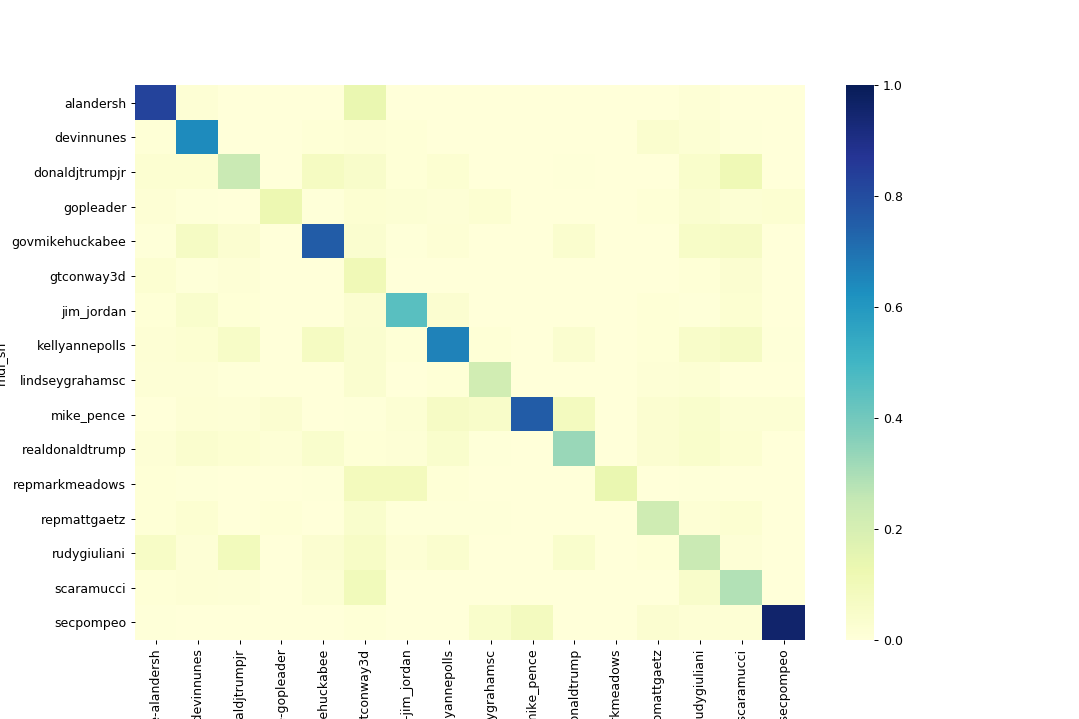

In [38]:
fig, ax = plt.subplots(figsize=(12,8))
sns.heatmap(score_df, cmap='YlGnBu', ax=ax, vmin=0, vmax=1)
# plt.figure(figsize=(20,20))
plt.show()

### Persist / Save Trained Models to Files

Save to local file system.  
Another notebook will handle saving to database.

In [165]:
#  Save vectorizer
pickle.dump(vect, open(f'{model_persist_dir}/{group}-mnbv1-vectorizer.pik', 'wb'))

In [166]:
#  Save calibrated model files
pickle.dump(model_nb, open(f'{model_persist_dir}/{group}-mnbv1-similarity.pik', 'wb'))